In [1]:
import sys

sys.path.append('../xor_neuron')

In [2]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

In [3]:
import pickle
from glob import glob
import os
import yaml
from easydict import EasyDict as edict
import numpy as np
import torch
from scipy.signal import convolve2d, fftconvolve, convolve
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.spatial.distance import cosine

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages

from model import *
from utils.train_helper import save_outphase, make_mask, load_model

In [4]:
exp_dir = [['../exp/xor_neuron_mlp_mnist/*', '../exp/MLP_Control_Model/MNIST/*', "../exp/MLP_1D_arg/MNIST/*"],
        ['../exp/xor_neuron_mlp_cifar/*', '../exp/MLP_Control_Model/CIFAR10/*', "../exp/MLP_1D_arg/CIFAR10/*"],
        ['../exp/xor_neuron_conv_mnist/*', '../exp/Conv_Control_Model/MNIST/*', "../exp/Conv_1D_arg/MNIST/*"],
        ['../exp/xor_neuron_conv_cifar/*', '../exp/Conv_Control_Model/CIFAR10/*', "../exp/Conv_1D_arg/CIFAR10/*"]]

In [15]:
exp_dir[0]

['../exp/xor_neuron_mlp_mnist/*',
 '../exp/MLP_Control_Model/MNIST/*',
 '../exp/MLP_1D_arg/MNIST/*']

In [5]:
control_dirs = glob('../exp/MLP_Control_Model/MNIST/*')
control_dirs.sort(key=os.path.abspath)
control_dirs

['../exp/MLP_Control_Model/MNIST/Control_MLP_1_mnist_0650',
 '../exp/MLP_Control_Model/MNIST/Control_MLP_2_mnist_0650',
 '../exp/MLP_Control_Model/MNIST/Control_MLP_3_mnist_0650',
 '../exp/MLP_Control_Model/MNIST/Control_MLP_4_mnist_0651']

In [6]:
dirs_1D = glob("../exp/MLP_1D_arg/MNIST/*")
dirs_1D.sort(key=os.path.abspath)
dirs_1D

['../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_1_mnist_0954',
 '../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_2_mnist_0954',
 '../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_3_mnist_0954',
 '../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_4_mnist_0955']

In [7]:
std_xor_phase1 = []
std_xor_phase2 = []

xorNeuron_avg_acc_phase1 = np.zeros(200)
xorNeuron_avg_acc_phase2 = np.zeros(400)

for ii, dr in enumerate(dirs):
    config_file = glob(dr + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    phase1_file = glob(dr + '/train_stats_phase1.p')[0]
    phase2_file = glob(dr + '/train_stats_phase2.p')[0]
    phase1_data = pickle.load(open(phase1_file, 'rb'))
    phase2_data = pickle.load(open(phase2_file, 'rb'))

    std_xor_phase1.append(torch.Tensor(phase1_data['val_acc']))
    xorNeuron_avg_acc_phase1 += np.array(phase1_data['val_acc'])
    
    std_xor_phase2.append(torch.Tensor(phase2_data['val_acc']))
    xorNeuron_avg_acc_phase2 += np.array(phase2_data['val_acc'])

xorNeuron_avg_acc_phase1 = xorNeuron_avg_acc_phase1 / len(dirs) * 100
xorNeuron_avg_acc_phase2 = xorNeuron_avg_acc_phase2 / len(dirs) * 100

std_xor_neuron_phase1 = torch.stack([std_xor_phase1[0], std_xor_phase1[1], std_xor_phase1[2], std_xor_phase1[3]])
std_xor_neuron_phase1 = torch.std(std_xor_neuron_phase1, dim=0).numpy()
std_xor_neuron_phase1 = std_xor_neuron_phase1 * 100 /2

std_xor_neuron_phase2 = torch.stack([std_xor_phase2[0], std_xor_phase2[1], std_xor_phase2[2], std_xor_phase2[3]])
std_xor_neuron_phase2 = torch.std(std_xor_neuron_phase2, dim=0).numpy()
std_xor_neuron_phase2 = std_xor_neuron_phase2 * 100 /2

NameError: name 'dirs' is not defined

In [9]:
control_std = []
contorl_avg_acc = np.zeros(400)

for ii, dr in enumerate(control_dirs):
    control_phase_file = glob(dr + '/control_train_stats.p')[0]
    control_data = pickle.load(open(control_phase_file, 'rb'))
    
    control_std.append(torch.Tensor(control_data['val_acc']))
    contorl_avg_acc += np.array(control_data['val_acc'])
    
contorl_avg_acc = contorl_avg_acc / len(control_dirs) * 100

std_control = torch.stack([control_std[0], control_std[1], control_std[2], control_std[3]])
std_control = torch.std(std_control, dim=0).numpy()
std_control = std_control * 100 /2

In [11]:
std_1D_xor_phase1 = []
std_1D_xor_phase2 = []

xorNeuron_1D_avg_acc_phase1 = np.zeros(200)
xorNeuron_1D_avg_acc_phase2 = np.zeros(400)

for ii, dr in enumerate(dirs_1D):
    phase1_file = glob(dr + '/train_stats_phase1.p')[0]
    phase2_file = glob(dr + '/train_stats_phase2.p')[0]
    phase1_data = pickle.load(open(phase1_file, 'rb'))
    phase2_data = pickle.load(open(phase2_file, 'rb'))

    std_1D_xor_phase1.append(torch.Tensor(phase1_data['val_acc']))
    xorNeuron_1D_avg_acc_phase1 += np.array(phase1_data['val_acc'])
    
    std_1D_xor_phase2.append(torch.Tensor(phase2_data['val_acc']))
    xorNeuron_1D_avg_acc_phase2 += np.array(phase2_data['val_acc'])

xorNeuron_1D_avg_acc_phase1 = xorNeuron_avg_acc_phase1 / len(dirs_1D) * 100
xorNeuron_1D_avg_acc_phase2 = xorNeuron_avg_acc_phase2 / len(dirs_1D) * 100

std_xor_neuron_1D_phase1 = torch.stack([std_1D_xor_phase1[0], std_1D_xor_phase1[1], std_1D_xor_phase1[2], std_1D_xor_phase1[3]])
std_xor_neuron_1D_phase1 = torch.std(std_xor_neuron_1D_phase1, dim=0).numpy()
std_xor_neuron_1D_phase1 = std_xor_neuron_1D_phase1 * 100 /2

std_xor_neuron_1D_phase2 = torch.stack([std_1D_xor_phase2[0], std_1D_xor_phase2[1], std_1D_xor_phase2[2], std_1D_xor_phase2[3]])
std_xor_neuron_1D_phase2 = torch.std(std_xor_neuron_1D_phase2, dim=0).numpy()
std_xor_neuron_1D_phase2 = std_xor_neuron_1D_phase2 * 100 /2

In [12]:
 epoch = np.arange(600)

IndexError: list index out of range

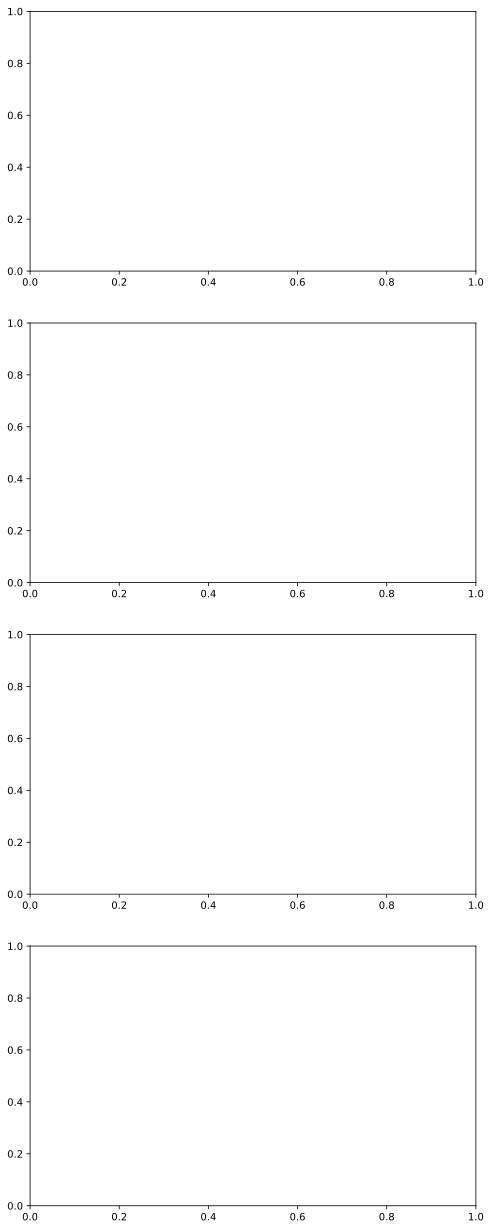

In [13]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(8,22))

for ii, exp in enumerate(exp_dir):
    dirs = glob(exp[0])
    control_dirs = glob(exp[1])
    dirs_1D = glob(exp[2])
    
    #--------------------- Get 2D Xor Neuron Avg acc, std ----------------------#
    std_xor_phase1 = []
    std_xor_phase2 = []

    xorNeuron_avg_acc_phase1 = np.zeros(200)
    xorNeuron_avg_acc_phase2 = np.zeros(400)

    for dr in dirs:
        config_file = glob(dr + '/*.yaml')[0]
        config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

        phase1_file = glob(dr + '/train_stats_phase1.p')[0]
        phase2_file = glob(dr + '/train_stats_phase2.p')[0]
        phase1_data = pickle.load(open(phase1_file, 'rb'))
        phase2_data = pickle.load(open(phase2_file, 'rb'))

        std_xor_phase1.append(torch.Tensor(phase1_data['val_acc']))
        xorNeuron_avg_acc_phase1 += np.array(phase1_data['val_acc'])

        std_xor_phase2.append(torch.Tensor(phase2_data['val_acc']))
        xorNeuron_avg_acc_phase2 += np.array(phase2_data['val_acc'])

    xorNeuron_avg_acc_phase1 = xorNeuron_avg_acc_phase1 / len(dirs) * 100
    xorNeuron_avg_acc_phase2 = xorNeuron_avg_acc_phase2 / len(dirs) * 100

    std_xor_neuron_phase1 = torch.stack([std_xor_phase1[0], std_xor_phase1[1], std_xor_phase1[2], std_xor_phase1[3]])
    std_xor_neuron_phase1 = torch.std(std_xor_neuron_phase1, dim=0).numpy()
    std_xor_neuron_phase1 = std_xor_neuron_phase1 * 100 /2

    std_xor_neuron_phase2 = torch.stack([std_xor_phase2[0], std_xor_phase2[1], std_xor_phase2[2], std_xor_phase2[3]])
    std_xor_neuron_phase2 = torch.std(std_xor_neuron_phase2, dim=0).numpy()
    std_xor_neuron_phase2 = std_xor_neuron_phase2 * 100 /2
    
    #--------------------- Get 1D Xor Neuron Avg acc, std ----------------------#
    std_1D_xor_phase1 = []
    std_1D_xor_phase2 = []

    xorNeuron_1D_avg_acc_phase1 = np.zeros(200)
    xorNeuron_1D_avg_acc_phase2 = np.zeros(400)

    for dr in dirs_1D:
        phase1_file = glob(dr + '/train_stats_phase1.p')[0]
        phase2_file = glob(dr + '/train_stats_phase2.p')[0]
        phase1_data = pickle.load(open(phase1_file, 'rb'))
        phase2_data = pickle.load(open(phase2_file, 'rb'))

        std_1D_xor_phase1.append(torch.Tensor(phase1_data['val_acc']))
        xorNeuron_1D_avg_acc_phase1 += np.array(phase1_data['val_acc'])

        std_1D_xor_phase2.append(torch.Tensor(phase2_data['val_acc']))
        xorNeuron_1D_avg_acc_phase2 += np.array(phase2_data['val_acc'])

    xorNeuron_1D_avg_acc_phase1 = xorNeuron_1D_avg_acc_phase1 / len(dirs) * 100
    xorNeuron_1D_avg_acc_phase2 = xorNeuron_1D_avg_acc_phase2 / len(dirs) * 100

    std_xor_neuron_1D_phase1 = torch.stack([std_1D_xor_phase1[0], std_1D_xor_phase1[1], std_1D_xor_phase1[2], std_1D_xor_phase1[3]])
    std_xor_neuron_1D_phase1 = torch.std(std_xor_neuron_1D_phase1, dim=0).numpy()
    std_xor_neuron_1D_phase1 = std_xor_neuron_1D_phase1 * 100 /2

    std_xor_neuron_1D_phase2 = torch.stack([std_1D_xor_phase2[0], std_1D_xor_phase2[1], std_1D_xor_phase2[2], std_1D_xor_phase2[3]])
    std_xor_neuron_1D_phase2 = torch.std(std_xor_neuron_1D_phase2, dim=0).numpy()
    std_xor_neuron_1D_phase2 = std_xor_neuron_1D_phase2 * 100 /2

    #--------------------- Get Control Avg acc, std ----------------------#
    control_std = []
    control_avg_acc = np.zeros(400)

    for dr in control_dirs:
        control_phase_file = glob(dr + '/control_train_stats.p')[0]
        control_data = pickle.load(open(control_phase_file, 'rb'))

        control_std.append(torch.Tensor(control_data['val_acc']))
        control_avg_acc += np.array(control_data['val_acc'])

    control_avg_acc = control_avg_acc / len(dirs) * 100

    std_control = torch.stack([control_std[0], control_std[1], control_std[2], control_std[3]])
    std_control = torch.std(std_control, dim=0).numpy()
    std_control = std_control * 100 /2
    
    
    #--------------------- Phase 1 ----------------------#
    ax[ii].plot(epoch[:200], xorNeuron_avg_acc_phase1, color='#CC4F1B')
    ax[ii].fill_between(epoch[:200], xorNeuron_avg_acc_phase1+std_xor_neuron_phase1, 
                    xorNeuron_avg_acc_phase1-std_xor_neuron_phase1, 
                    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

    ax[ii].plot(epoch[:200], xorNeuron_1D_avg_acc_phase1, color='#3F7F4C')
    ax[ii].fill_between(epoch[:200], xorNeuron_1D_avg_acc_phase1+std_xor_neuron_1D_phase1, 
                    xorNeuron_1D_avg_acc_phase1-std_xor_neuron_1D_phase1, 
                    alpha=0.5, edgecolor='#3F7F4C', facecolor='#7EFF99')   
    
    #--------------------- Phase 2 ----------------------#
    ax[ii].plot(epoch[200:], xorNeuron_avg_acc_phase2, color='#CC4F1B', label = '2-D arg')
    ax[ii].fill_between(epoch[200:], xorNeuron_avg_acc_phase2+std_xor_neuron_phase2, 
                    xorNeuron_avg_acc_phase2-std_xor_neuron_phase2, 
                    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

    ax[ii].plot(epoch[200:], control_avg_acc, color='#1B2ACC', label = 'control_1')
    ax[ii].fill_between(epoch[200:], control_avg_acc+std_control, control_avg_acc-std_control, 
                    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')

    ax[ii].plot(epoch[200:], xorNeuron_1D_avg_acc_phase2, color='#3F7F4C', label = '1-D arg')
    ax[ii].fill_between(epoch[200:], xorNeuron_1D_avg_acc_phase2+std_xor_neuron_1D_phase2, 
                    xorNeuron_1D_avg_acc_phase2-std_xor_neuron_1D_phase2, 
                    alpha=0.5, edgecolor='#3F7F4C', facecolor='#7EFF99')

    if config.dataset.name == 'mnist':
        if config.model.inner_net == 'conv':
            ax[ii].set_ylim(98,100)
            ax[ii].set_yticks([98, 99, 100])

        elif config.model.inner_net == 'mlp':
            ax[ii].set_ylim(96,100)
            ax[ii].set_yticks([96, 98, 100])           

    elif config.dataset.name == 'cifar10':
        if config.model.inner_net == 'conv':
            ax[ii].set_ylim(60,90)
            ax[ii].set_yticks([60, 70, 80, 90])

        elif config.model.inner_net == 'mlp':
            ax[ii].set_ylim(40,55)
            ax[ii].set_yticks([40, 50])


    ax[ii].set_xlabel('epoch')
    ax[ii].set_ylabel('accuracy (%)')

    ax[ii].grid(True)
    ax[ii].legend()
    
    ax[ii].set_title(f'{config.model.inner_net.upper()} {config.dataset.name.upper()}')

# f.savefig('./mean_std.pdf')    
f.show()